
# 🔁 Modelo de Churn con Keras + Embeddings (Variables Categóricas de Alto Cardinalidad)

Este notebook construye un **modelo de red neuronal** con **Keras** para predecir **churn** (abandono),
utilizando **embeddings** para variables categóricas con alto cardinalidad (por ejemplo, `user_id`, `city`, `plan_id`).

**Incluye:**
- Generación de **dataset sintético realista** para churn con variables numéricas y categóricas (alto cardinalidad).
- División **estratificada** train/valid/test.
- **Preprocesamiento**: escalado de numéricas y codificación de categorías para **embeddings**.
- **Arquitectura con embeddings** + capas densas con regularización.
- **Callbacks**: EarlyStopping y ReduceLROnPlateau.
- **Métricas**: ROC-AUC, PR-AUC, F1, Accuracy, KS; y curvas ROC/PR, matriz de confusión y calibración.
- **Permutation Importance** sobre las entradas (aprox.).


In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             f1_score, accuracy_score, confusion_matrix,
                             precision_recall_curve, roc_curve)
from scipy.stats import ks_2samp

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(42)
tf.random.set_seed(42)


In [5]:

# --- Generación de dataset sintético de churn ---
n = 60000

# Alto cardinalidad
user_id = np.random.choice(np.arange(100000, 200000), size=n, replace=True)
city_id = np.random.choice(np.arange(5000), size=n, replace=True)  # 5k ciudades
plan_id = np.random.choice(np.arange(200), size=n, replace=True)

# Numéricas
tenure_months = np.random.gamma(5.0, 3.0, size=n)  # sesgada
monthly_spend = np.abs(np.random.normal(25, 10, size=n)) + 5
support_tickets = np.random.poisson(1.2, size=n)
discount_pct = np.clip(np.random.beta(2,8, size=n)*100, 0, 60)
late_payments = np.random.poisson(0.3, size=n)
usage_hours = np.abs(np.random.normal(40, 12, size=n))

# Señal de churn (probabilidad latente)
# Efectos: pocos meses, muchos tickets, alta morosidad, bajo uso → más churn
logit = (
    -1.2
    - 0.08*tenure_months
    + 0.25*support_tickets
    + 0.45*late_payments
    - 0.03*usage_hours
    - 0.01*discount_pct
)
# Efectos categóricos (embeddings deben capturarlos)
# clusters de city y plan con mayor churn
city_hot = (city_id % 23 == 0).astype(float) * 0.6
plan_hot = (plan_id % 17 == 0).astype(float) * 0.4
logit = logit + city_hot + plan_hot

p = 1/(1+np.exp(-logit))
y = (np.random.rand(n) < p).astype(int)

df = pd.DataFrame({
    "user_id": user_id,
    "city_id": city_id,
    "plan_id": plan_id,
    "tenure_months": tenure_months,
    "monthly_spend": monthly_spend,
    "support_tickets": support_tickets,
    "discount_pct": discount_pct,
    "late_payments": late_payments,
    "usage_hours": usage_hours,
    "churn": y
})

print(df.head(), "\n\nChurn rate:", df['churn'].mean().round(4))


   user_id  city_id  plan_id  tenure_months  monthly_spend  support_tickets  \
0   115795     1837      177      12.614609      34.388234                1   
1   100860      565      181      14.647866      24.162434                1   
2   176820     3691      184      20.232876      38.437495                0   
3   154886     3898       13      15.231194      36.001901                3   
4   106265      800      130      25.322551      33.799965                1   

   discount_pct  late_payments  usage_hours  churn  
0     11.479566              0    48.344410      0  
1     23.166589              0    39.053825      0  
2     26.915337              0    32.885019      0  
3     45.235456              1    47.129238      0  
4     23.207026              0    50.277566      0   

Churn rate: 0.0453


In [6]:

# --- Split estratificado ---
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["churn"])
train, val = train_test_split(train, test_size=0.2, random_state=42, stratify=train["churn"])

cat_cols = ["user_id", "city_id", "plan_id"]
num_cols = ["tenure_months", "monthly_spend", "support_tickets", "discount_pct", "late_payments", "usage_hours"]

# Escalado numérico
scaler = StandardScaler()
train_num = scaler.fit_transform(train[num_cols])
val_num = scaler.transform(val[num_cols])
test_num = scaler.transform(test[num_cols])

# Mapas de ID a índices (para embeddings)
id_maps = {}
vocab_sizes = {}
train_cats = {}
val_cats = {}
test_cats = {}

for col in cat_cols:
    uniques = pd.Index(sorted(df[col].unique()))
    id2idx = {v:i for i,v in enumerate(uniques)}
    id_maps[col] = id2idx
    vocab_sizes[col] = len(uniques)
    train_cats[col] = train[col].map(id2idx).values
    val_cats[col] = val[col].map(id2idx).values
    test_cats[col] = test[col].map(id2idx).values

y_train = train["churn"].values
y_val = val["churn"].values
y_test = test["churn"].values

print("Vocab sizes:", vocab_sizes)


Vocab sizes: {'user_id': 45165, 'city_id': 5000, 'plan_id': 200}


In [7]:

# --- Modelo Keras con embeddings para cada categoría ---
def emb_dim(vocab):
    # regla común: min(50, round(vocab**0.25 * 4))
    return int(min(50, max(4, round(vocab**0.25 * 4))))

inputs = []
emb_layers = []

for col in cat_cols:
    inp = keras.Input(shape=(1,), name=f"{col}_in", dtype="int32")
    dim = emb_dim(vocab_sizes[col])
    emb = layers.Embedding(input_dim=vocab_sizes[col], output_dim=dim, name=f"{col}_emb")(inp)
    emb = layers.Reshape((dim,))(emb)
    inputs.append(inp)
    emb_layers.append(emb)

num_inp = keras.Input(shape=(len(num_cols),), name="num_in")
inputs.append(num_inp)

x = layers.Concatenate()(emb_layers + [num_inp])
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=out)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.AUC(name="auc_roc", curve="ROC"),
             keras.metrics.AUC(name="auc_pr", curve="PR")]
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ city_id_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ plan_id_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_id_emb         │ (None, 1, 50)     │  2,258,250 │ user_id_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ city_id_emb         │ (None, 1, 34)     │    170,000 │ city_id_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ plan_id_emb         │ (None, 1, 15)     │      3,000 │ plan_id_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50)        │          0 │ user_id_emb[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 34)        │          0 │ city_id_emb[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 15)        │          0 │ plan_id_emb[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 6)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 105)       │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ reshape_1[0][0],  │
│                     │                   │            │ reshape_2[0][0],  │
│                     │                   │            │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 105)       │        420 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     13,568 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,453,559 (9.36 MB)

 Trainable params: 2,453,349 (9.36 MB)

 Non-trainable params: 210 (840.00 B)

In [8]:

# --- Preparar tensores de entrada y class weights ---
X_train = {f"{c}_in": train_cats[c] for c in cat_cols}
X_train["num_in"] = train_num

X_val = {f"{c}_in": val_cats[c] for c in cat_cols}
X_val["num_in"] = val_num

X_test = {f"{c}_in": test_cats[c] for c in cat_cols}
X_test["num_in"] = test_num

pos = y_train.mean()
w_pos = 0.5/pos
w_neg = 0.5/(1-pos)
class_weight = {0: w_neg, 1: w_pos}
class_weight


{0: 0.5237458741373195, 1: 11.02814474439977}

In [9]:

# --- Entrenamiento ---
cb = [
    keras.callbacks.EarlyStopping(monitor="val_auc_pr", patience=5, mode="max", restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_auc_pr", factor=0.5, patience=3, mode="max", min_lr=1e-5, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40, batch_size=1024,
    class_weight=class_weight,
    callbacks=cb, verbose=2
)


Epoch 1/40
38/38 - 10s - 262ms/step - auc_pr: 0.0479 - auc_roc: 0.5194 - loss: 0.7389 - val_auc_pr: 0.0944 - val_auc_roc: 0.6868 - val_loss: 0.6976 - learning_rate: 0.0010
Epoch 2/40
38/38 - 2s - 43ms/step - auc_pr: 0.2006 - auc_roc: 0.7993 - loss: 0.5890 - val_auc_pr: 0.0975 - val_auc_roc: 0.6912 - val_loss: 0.6411 - learning_rate: 0.0010
Epoch 3/40
38/38 - 2s - 61ms/step - auc_pr: 0.5755 - auc_roc: 0.9529 - loss: 0.3352 - val_auc_pr: 0.0932 - val_auc_roc: 0.6833 - val_loss: 0.3445 - learning_rate: 0.0010
Epoch 4/40
38/38 - 3s - 67ms/step - auc_pr: 0.9143 - auc_roc: 0.9960 - loss: 0.1066 - val_auc_pr: 0.0816 - val_auc_roc: 0.6657 - val_loss: 0.2062 - learning_rate: 0.0010
Epoch 5/40

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
38/38 - 2s - 64ms/step - auc_pr: 0.9621 - auc_roc: 0.9990 - loss: 0.0439 - val_auc_pr: 0.0766 - val_auc_roc: 0.6568 - val_loss: 0.2069 - learning_rate: 0.0010
Epoch 6/40
38/38 - 2s - 58ms/step - auc_pr: 0.9835 - auc_roc: 0.9995 - 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Validación ROC-AUC: 0.6915
Validación PR-AUC:  0.0987
Validación F1:      0.1383
Validación Acc:     0.6547
Validación KS:      0.2890


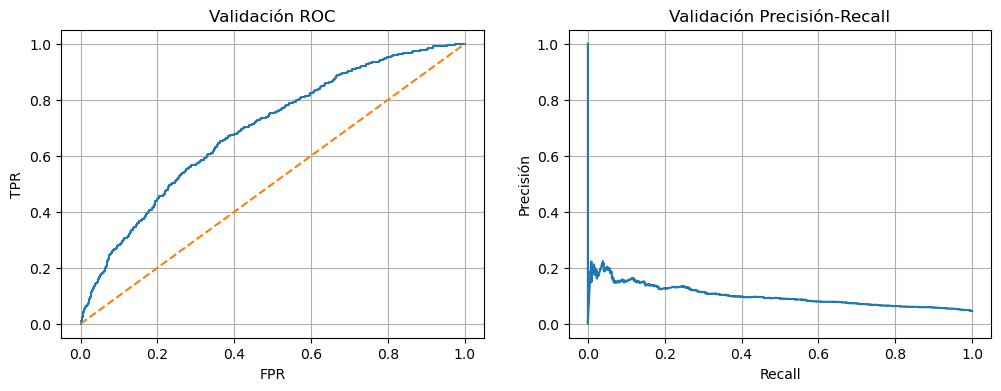

Matriz de confusión:
 [[6019 3146]
 [ 169  266]]
Test ROC-AUC: 0.6781
Test PR-AUC:  0.0974
Test F1:      0.1336
Test Acc:     0.6551
Test KS:      0.2696


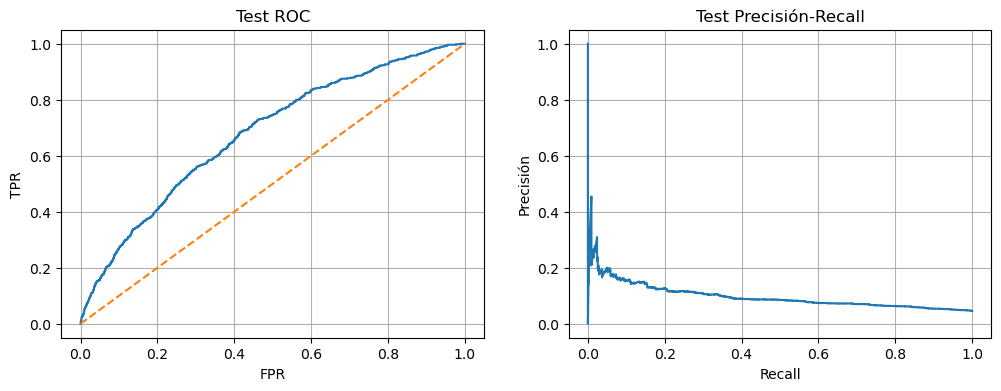

Matriz de confusión:
 [[7542 3914]
 [ 225  319]]


In [10]:

# --- Evaluación ---
def metrics_and_plots(y_true, y_proba, title_prefix="Test"):
    y_pred = (y_proba >= 0.5).astype(int)
    roc = roc_auc_score(y_true, y_proba)
    pr = average_precision_score(y_true, y_proba)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    ks = ks_2samp(y_proba[y_true==1], y_proba[y_true==0]).statistic

    print(f"{title_prefix} ROC-AUC: {roc:.4f}")
    print(f"{title_prefix} PR-AUC:  {pr:.4f}")
    print(f"{title_prefix} F1:      {f1:.4f}")
    print(f"{title_prefix} Acc:     {acc:.4f}")
    print(f"{title_prefix} KS:      {ks:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    prec, rec, _ = precision_recall_curve(y_true, y_proba)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], "--")
    plt.title(f"{title_prefix} ROC")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(rec, prec)
    plt.title(f"{title_prefix} Precisión-Recall")
    plt.xlabel("Recall"); plt.ylabel("Precisión"); plt.grid(True)
    plt.show()

    cm = confusion_matrix(y_true, y_pred)
    print("Matriz de confusión:\n", cm)

# Predicción y métricas
y_proba_val = model.predict(X_val, batch_size=4096).ravel()
y_proba_test = model.predict(X_test, batch_size=4096).ravel()

metrics_and_plots(y_val, y_proba_val, "Validación")
metrics_and_plots(y_test, y_proba_test, "Test")


C:\Users\User\AppData\Local\Temp\ipykernel_13608\2479026508.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfc.groupby("bin").agg(mean_p=("p","mean"), event_rate=("y","mean"), n=("y","count")).reset_index()


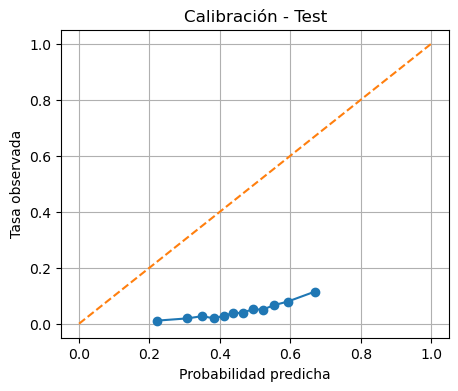

,bin,mean_p,event_rate,n
0,"(0.047099999999999996, 0.277]",0.221317,0.011,1000
1,"(0.277, 0.332]",0.306826,0.019,1000
2,"(0.332, 0.368]",0.350007,0.027,1000
3,"(0.368, 0.399]",0.383567,0.019,1000
4,"(0.399, 0.425]",0.412260,0.029,1000


In [11]:

# --- Calibración ---
def calibration_plot(y_true, y_proba, bins=10, title="Curva de Calibración"):
    dfc = pd.DataFrame({"y": y_true, "p": y_proba})
    dfc["bin"] = pd.qcut(dfc["p"], q=bins, duplicates="drop")
    grouped = dfc.groupby("bin").agg(mean_p=("p","mean"), event_rate=("y","mean"), n=("y","count")).reset_index()
    plt.figure(figsize=(5,4))
    plt.plot(grouped["mean_p"], grouped["event_rate"], marker="o")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("Probabilidad predicha")
    plt.ylabel("Tasa observada")
    plt.title(title)
    plt.grid(True)
    plt.show()
    return grouped

calib = calibration_plot(y_test, y_proba_test, bins=12, title="Calibración - Test")
calib.head()


In [12]:

# --- Importancia por permutación (aprox. numéricas) ---
base_pr = average_precision_score(y_val, y_proba_val)

def perm_importance_num():
    importances = {}
    for j, col in enumerate(num_cols):
        Xv = X_val.copy()
        Xv["num_in"] = Xv["num_in"].copy()
        Xv["num_in"] = Xv["num_in"].copy()
        Xv_num = Xv["num_in"].copy()
        # permutar la columna j en el array escalado
        Xv_num_perm = Xv_num.copy()
        Xv_num_perm[:, j] = np.random.permutation(Xv_num_perm[:, j])
        Xv_perm = Xv.copy()
        Xv_perm["num_in"] = Xv_num_perm
        pr = average_precision_score(y_val, model.predict(Xv_perm, batch_size=4096).ravel())
        importances[col] = base_pr - pr
    return importances

num_cols_list = num_cols


In [13]:

importances = {}
try:
    importances = eval("perm_importance_num()")
    print("Importancias (ΔPR-AUC por permutación en numéricas):")
    for k,v in sorted(importances.items(), key=lambda kv: kv[1], reverse=True):
        print(f"{k}: {v:.5f}")
except Exception as e:
    print("Permutation importance omitida por:", e)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Importancias (ΔPR-AUC por permutación en numéricas):
late_payments: 0.02507
tenure_months: 0.01872
support_tickets: 0.01463
usage_hours: 0.01302
monthly_spend: 0.00122
discount_pct: -0.00107
